# Address completeness classification with traditional programming techniques
Data & AI course, UC Leuven, 2021 Fall
### Project supervisors
- Tom Magerman
- Aimée Lynn Backiel

### Project team (Group 4)
- Karolis Medekša
- Pedro Teixeira Palma Rosa
- Hysa Mello de Alcântara
- Josep Jacob Chetrit Valdepeñas

## Goals
The goal if the assignment to implement a Python program that is capable of determining whether a provided street address is complete (having a street name, house/apartment number, postal code, city) or incomplete (missing any of previously mentioned criteria).

# Implementation
The first step of solving the problem is reading the input file into an object of `pandas.DataFrame`. Function `read_DataFrame_from_file` is responsible for that. While doing the exercise it is also convenient to output the data table to excel for an easier inspection, `write_DataFrame_to_excel` is responsible for that, the function not only outputs the data frame to an excel file, but also adds additional formatting, for instance, coloring rows of complete addresses in green and those that are incomplete - in red.  

In [2]:
import pandas as pd

DATA_INPUT_FILENAME = 'input.txt'
DATA_OUTPUT_FILENAME = 'classified.xlsx'

def read_DataFrame_from_file():
    return pd.read_csv(DATA_INPUT_FILENAME, delimiter='\t')


def write_DataFrame_to_excel(df: pd.DataFrame):
    sheet_name = 'Classified'

    with pd.ExcelWriter(DATA_OUTPUT_FILENAME, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        worksheet = writer.sheets[sheet_name]
        # format all data as a table
        worksheet.add_table(0, 0, df.shape[0], df.shape[1]-1, {
            'columns': [{'header': col_name} for col_name in df.columns],
            'style': 'Table Style Medium 5'
        })
        # Widen the address column
        worksheet.set_column('C:C', 70)

        # Add formatting - red for negative, green - for positive qualification
        redFormat = writer.book.add_format({'bg_color': '#FF0000', 'font_color': '#000000'})
        greenFormat = writer.book.add_format({'bg_color': '#00B050', 'font_color': '#000000'})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=0',
                                          'format': redFormat})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=1',
                                          'format': greenFormat})

With the simplest possible strategy of classification (label all addresses as incomplete) we can verify that input/output behavior is working correctly

In [4]:
def classify_address(dataFrame: pd.DataFrame):
    dataFrame['complete'] = 0
    return dataFrame


def init():
    classified = classify_address(read_DataFrame_from_file())
    write_DataFrame_to_excel(classified)


init()

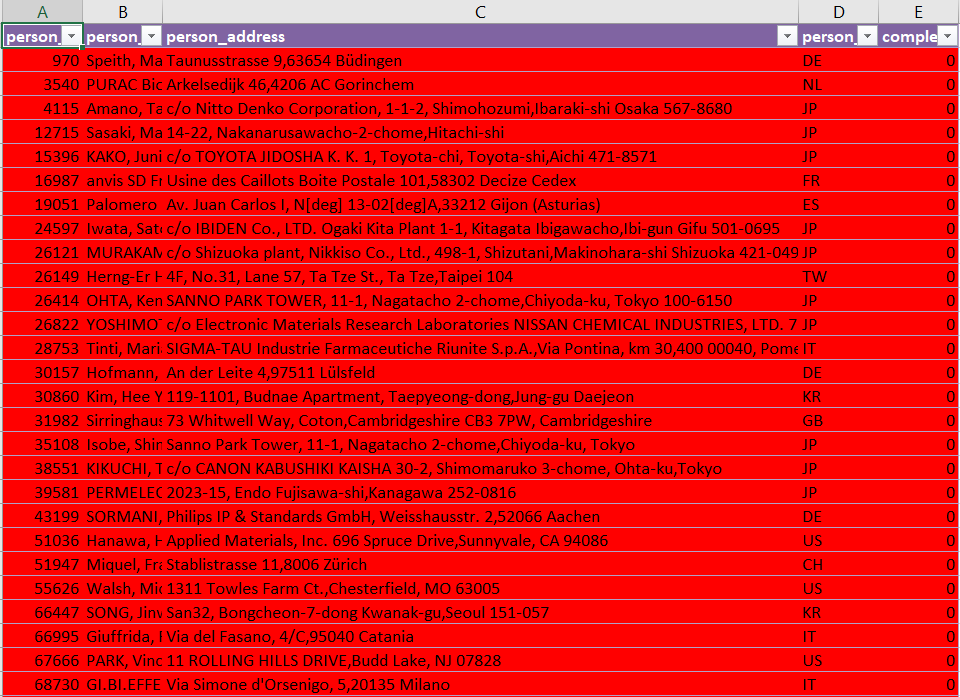

# Determining the postal code

TODO: Countries without any postal code: AN, BB, BD, BO, BS, CL, CR, CS, DO, EG, HK, IE, IR, KW, LK, PK, RS, SV, TN, UA, UG, VE, VN.
What to do with Taiwan and Japan? It's zip codes are only three numbers, the same as many house numbers

--------------
Postal code is one of the things which can be determined via regex, mainly because postal codes usually follow the same structure. However, the problem arises because different countries have varying postal code formats, moreover, in some addresses postal codes are international, in others - local.
Nevertheless, we can come up with checks that should account for the vast majority of cases - in most European countries postal codes are composed of a combination of one to three letters and number sequences. In other places, for instance Canada, we can find postal codes composed of six or more alphanumerical symbols. We can have a single regular expression, composed of more than one check, to capture all these cases (see the image below)

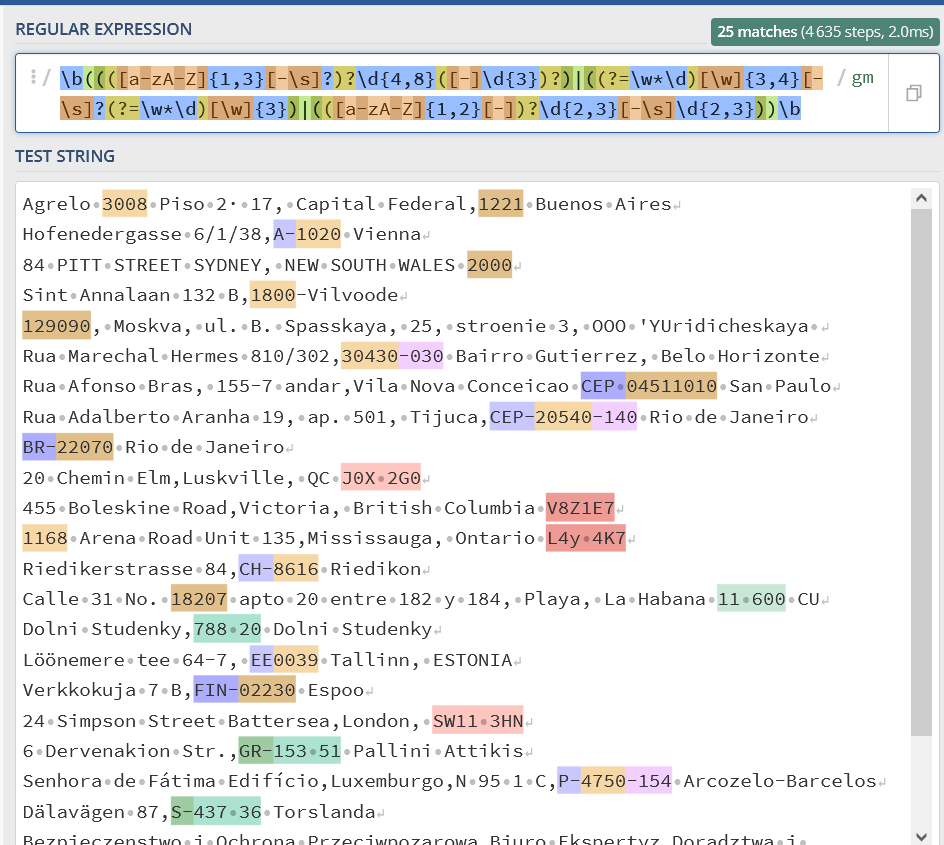

We can now implement a `reGex` check to test whether an address is complete or incomplete.

In [5]:
import re

POSTAL_CODE_REGEX = r'\b((([a-zA-Z]{1,3}[-\s]?)?\d{4,8}([-]\d{3})?)|((?=\w*\d)[\w]{3,4}[-\s]?(?=\w*\d)[\w]{3})|(([a-zA-Z]{1,2}[-])?\d{2,3}[-\s]\d{2,3}))\b'

def does_contain_valid_postal_code(input):
    match = re.search(POSTAL_CODE_REGEX, input)
    if (match is not None):
        return True
    return False


def is_valid_address(input):
    return does_contain_valid_postal_code(input)


def classify_address(dataFrame: pd.DataFrame):
    dataFrame['complete'] = dataFrame.apply(lambda row: 1 if is_valid_address(row['person_address']) else 0, axis=1)

    return dataFrame

df = pd.DataFrame({
    'person_address': [
        '206 rue St-Jacques,Longueuil, Québec J4W 3B9',
        'Ukmerges 17-27,LT-49317 Kaunas',
        'Larchmont,NY'
    ]
})
print(classify_address(df))

                                 person_address  complete
0  206 rue St-Jacques,Longueuil, Québec J4W 3B9         1
1                Ukmerges 17-27,LT-49317 Kaunas         1
2                                  Larchmont,NY         0


### TODO: Remove above documentation when unneeded ↑

# Address classification strategy

For the solution of this exercise several options were considered:
- Using regular expressions to find street names, house numbers, cities and postal codes. ReGex could work for a postal code, but other tokens are just too varying, even within the same country, to confidently create a single solution with regular expressions
- Searching a database of city/street names for matches in the address string. Due to an overwhelming number of street names in the world coding a solution for all of them is unfeasable. There are less city names, but even checking for them is troublesome - city's name could be anywhere within the address and they could be in different languages to boot.
- Using an already created address parsing library. Although easiest to implement, relying only on a library could end up being troublesome once it's limitations are reached.

## libpostal
An open source `C` library [libpostal](https://github.com/openvenues/libpostal) was chosen to parse the addresses, mainly because it provides wide parsing support across different countries and languages - relevant for the input dataset. 

On the other hand, the library is developed mainly for usage in `UNIX` operating systems, therefore, installing it on Windows OS is very troublesome. As an alternative it was decided to run an instance of a `libpostal` tool in a docker container.

For the implementation of the solution a Dockerfile from [Pelias project](https://github.com/pelias/libpostal-service) was used. It creates a container with an instance of a [Go web server](https://github.com/whosonfirst/go-whosonfirst-libpostal) which allows using `libpostal` via REST API.

### Setting up the docker container

1. Make sure that docker is installed on the host system
2. Build and start the docker container
```shell
docker run --name libpostal -d -p 4400:4400 pelias/libpostal-service
```
The command will pull the docker image from a remote repository along with all the data required for the service. Execution of the command can take a couple of minutes.
3. Verify that the service is working correctly
```shell
curl -s localhost:4400/parse?address=30+w+26th+st,+new+york,+ny
[{"label":"house_number","value":"30"},{"label":"road","value":"w 26th st"},{"label":"city","value":"new york"},{"label":"state","value":"ny"}]
```

### Using libpostal via API

The address can be parsed by simply passing it to the service entry point. Variuos information is extracted by the tool: street (road), house number, city, state, postal code and more.

```shell
curl -s localhost:4400/parse?address=83%20Sycamore%20Drive%2CReading%2C%20Pennsylvania%2019606 | py -m json.tool
[
    {
        "label": "house_number",
        "value": "83"
    },
    {
        "label": "road",
        "value": "sycamore drive"
    },
    {
        "label": "city",
        "value": "reading"
    },
    {
        "label": "state",
        "value": "pennsylvania"
    },
    {
        "label": "postcode",
        "value": "19606"
    }
]

```

### Using the library for classification
We can call the API to classify each address in the python script:

In [6]:
import requests

LIBPOSTAL_API_PARSE_PATH = 'http://localhost:4400/parse'

def enrich_row_with_address_details(row):
    error_response = [0, None, None, None, None]

    address = row['person_address']
    if not address:
        return error_response

    response = {}
    try:
        unmapped_response = requests.get(LIBPOSTAL_API_PARSE_PATH, params={ 'address': address }).json()
        response = { entry['label']: entry['value'] for entry in unmapped_response }
    except Exception as e:
        print('Failed to parse address {} | error: {}'.format(address, e))
        return error_response

    street = response['road'] if 'road' in response else None
    house_number = response['house_number']  if 'house_number' in response else None
    post_code = response['postcode']  if 'postcode' in response else None
    city = response['city']  if 'city' in response else None

    complete = 1 if street and house_number and post_code and city else 0
    
    return complete, street, house_number, post_code, city


def classify_address(dataFrame: pd.DataFrame):
    dataFrame[['complete', 'street', 'house', 'postal_code', 'city']] = dataFrame.apply(enrich_row_with_address_details, axis=1, result_type='expand')
    return dataFrame


def init():
    classified = classify_address(read_DataFrame_from_file())
    write_DataFrame_to_excel(classified)


init()

We can see that only a portion of all addresses are qualified correctly:
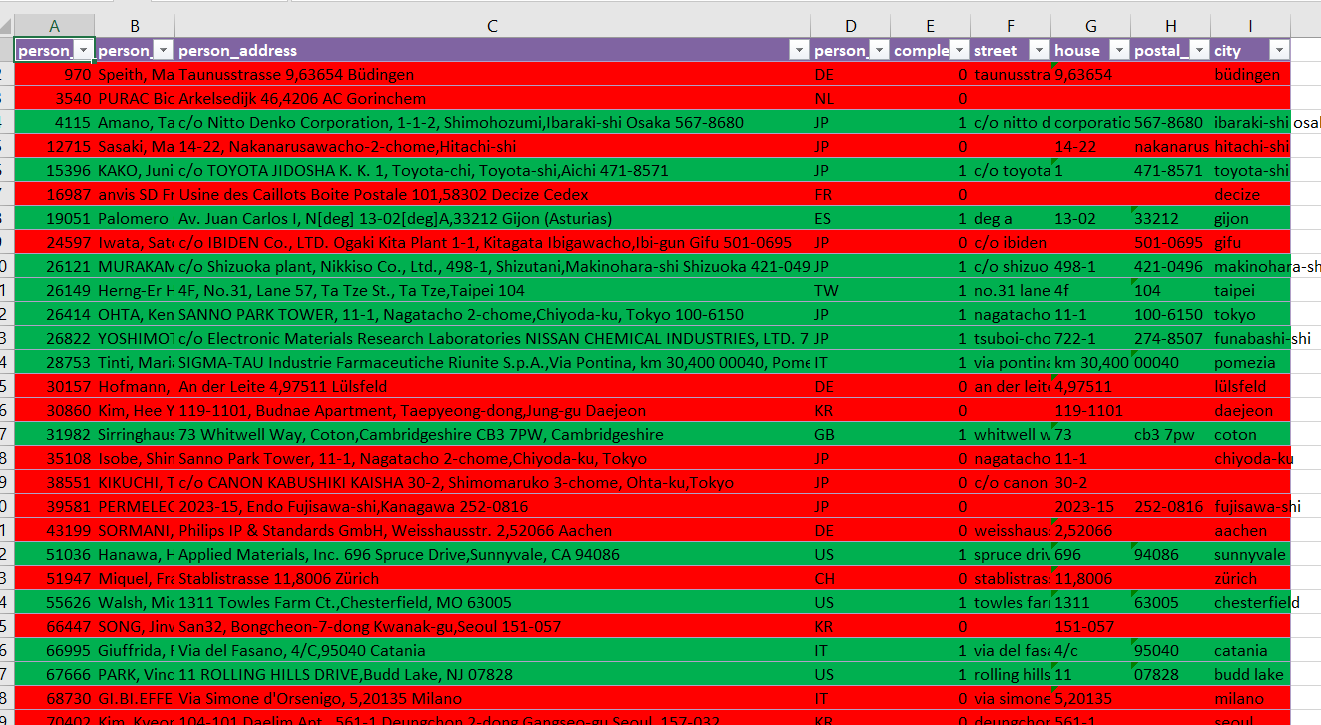

One of the issues is that the library sometimes gets confused if the address tokens are separated by commas not followed by a space. An example:



Taunusstrasse 9,63654 Büdingen:
```shell
curl -s localhost:4400/parse?address=Taunusstrasse%209%2C63654%20B%C3%BCdingen | py -m json.tool
[
    {
        "label": "road",
        "value": "taunusstrasse"
    },
    {
        "label": "house_number",
        "value": "9,63654"
    },
    {
        "label": "city",
        "value": "b\u00c3\u00bcdingen"
    }
]
```
Taunusstrasse 9, 63654 Büdingen:
```shell
curl -s localhost:4400/parse?address=Taunusstrasse%209%2C%2063654%20B%C3%BCdingen | py -m json.tool
[
    {
        "label": "road",
        "value": "taunusstrasse"
    },
    {
        "label": "house_number",
        "value": "9"
    },
    {
        "label": "postcode",
        "value": "63654"
    },
    {
        "label": "city",
        "value": "b\u00c3\u00bcdingen"
    }
]

```

After changing the code to replace all commas into commas with trailing spaces (`address = address.replace(',', ', ')`), we get more correct classifications:
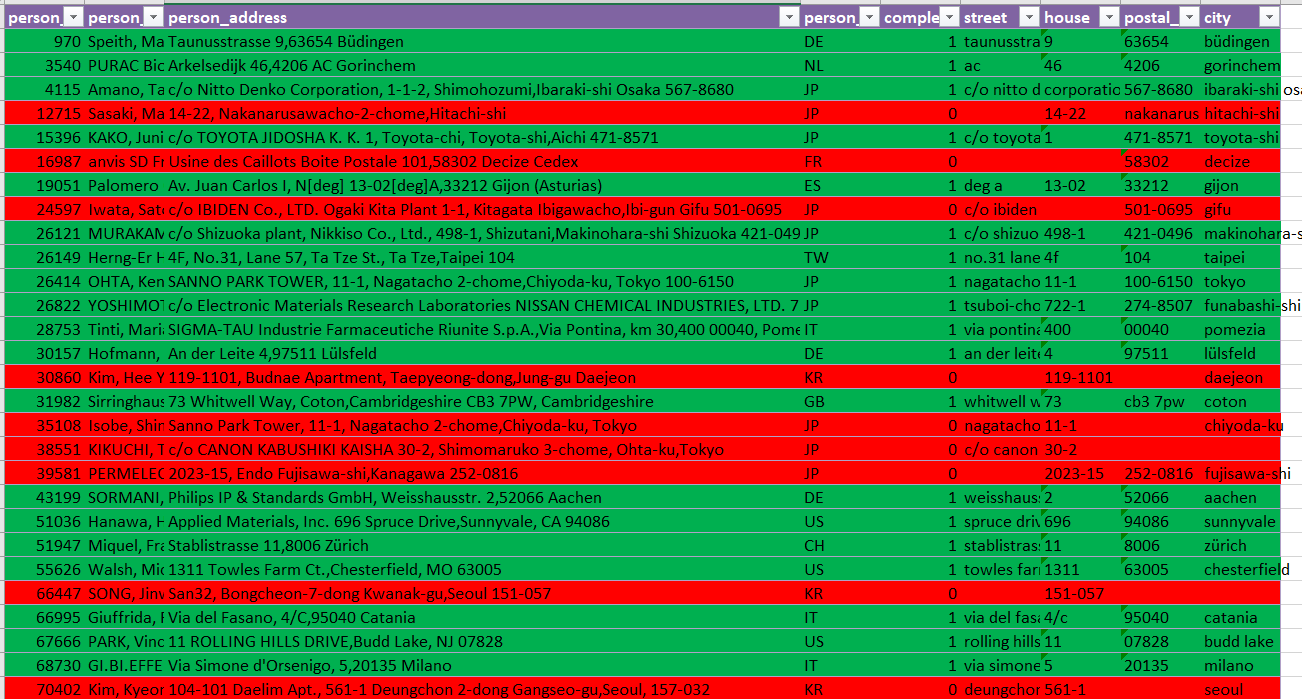

# Filtering before classification

Lots of  addresses didn't have the right amount of words or numbers to be classified. So to spare time to run the program we filtered each entry before it was classified to check if it had at least one group of numbers (postal code or house number) and thenat least 4 words (postal code, city, street and house number). We did that using the following functions:


In [8]:
    def contains_two_groups_number(input):
        if any(i.isdigit() for i in input):
            return check_group_of_words(input)
        return False


    def check_group_of_words(input):
        words = input.split()
        if len(words) > 3:
            return True
        return False
    
    if __name__ == '__main__':
        address_wrong = 'Midland, Michigan 48686-0995'
        address_right = 'Jebenhäuser Strasse 17,73035 Göppingen'
        
        print(f'Enough words and numbers in {address_wrong}: {contains_two_groups_number(address_wrong)}')
        print(f'Enough words and numbers in {address_right}: {contains_two_groups_number(address_right)}')

Enough words and numbers in Midland, Michigan 48686-0995: False
Enough words and numbers in Jebenhäuser Strasse 17,73035 Göppingen: True


        
Doing that we lower the time of running, not losing time trying to classify impossible addresses, that will not even start the classification and will be shown like this:

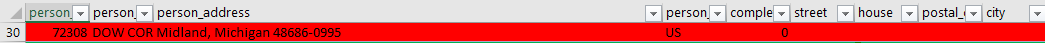